<h1 style='color:#00868b; text-align:center;'>BERT<span class="tocSkip"></span></h1>

# Introduction

## About BERT

Intro:

https://arxiv.org/pdf/1810.04805.pdf  
https://searchengineland.com/faq-all-about-the-bert-algorithm-in-google-search-324193  
https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270  

<font color='red'>todo</font>  
Word embedding = feature vector representation of a word on which BERT can do math.
Similar words will be close to each other. Unrelated words will be far apart. As such, the distance reflects word similarity. This is valuable to us. Feeding sentences into a neural network, such as 'I sat on the couch' and 'I sat on the sofa', will result into an output being relatively the same. Whatever knowledge it has gained about 'couch', it can also apply to 'sofa'. 
Individual values of the word embedding don't really matter. So long as the relative distances are the same, the word embeddings are doing their job.  
<font color='red'>todo</font>

BERT (**B**idirectional **E**ncoder **R**epresentations from **T**ransformers) is a deep learning model that was developed by Google for NLP tasks. BERT is a pre-trained model with an established vocabulary. You cannot add to this vocabulary. This seems like a problem, but BERT handles this cleverly. It uses a word piece model that breaks a word into multiple subwords if it does not appear in the vocabulary. As such, it breaks down unknown words into subwords (separate tokens). The token at the beginning of a word that is not featured in the BERT vocabulary can be redundant for the whole word. Every other token of this word starts with '##'. These are not wildcards but more like a flag to indicate these are not the first token of a word.

BERT **can** be used for a number of applications:
* Classification
* Named Entity Recognition
* Part of Speech Tagging
* Question Answering

BERT **cannot** be used for:
* Language modelling
* Text generation
* Translation

We will use BERT to address a multi-class classification problem, using our consumer complaint dataset.

## Why use BERT?

It is essential to properly represent language in such a way that is can be understood by machines. 

A **context-free** model, such as Word2Vec or GloVe, generate a single word embedding representation for each word in the vocabulary. For example, the word 'bank' would have the same representation in 'bank deposit' and in 'riverbank' ([source](https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03#:~:text=BERT%20theoretically%20allows%20us%20to,task%2Dspecific%20fine%2Dtuning.&text=BERT%20works%20similarly%20to%20the,new%20sequences%20are%20coming%20in.)).

**Contextual models**, on the other hand, generate a representation of each word that is based on the other words in the sentence. BERT is a contextual model and captures these relationships in a bidirectional way, hence the 'B' in BERT. The idea is to extract high-quality language features and fine-tune BERT on a specific task (classification) with our dataset to produce solid predictions.

## Installing BERT

Let's explore BERT first using the BERT by Hugging Face. This is a partially outdated version, but nonetheless interesting to explore. Our actual model will train using the more recent version from the package <code>transformers</code>.

Install pytorch:  
<code>conda install pytorch torchvision cudatoolkit=10.2 -c pytorch</code>.

Install the pytorch interface for BERT by Hugging Face using:  
<code>pip install pytorch-pretrained-bert</code>.

This is the base BERT and uncased (so everything is lowercased). BERT large is very big and less used in mainstream, though is required to achieve the paper's results for the 11 mentioned NLP tasks.

In [248]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

## Let's take a look at some statistics of the BERT vocabulary.

**What does the distribution of token lengths look like?**

Text(0, 0.5, '# of tokens')

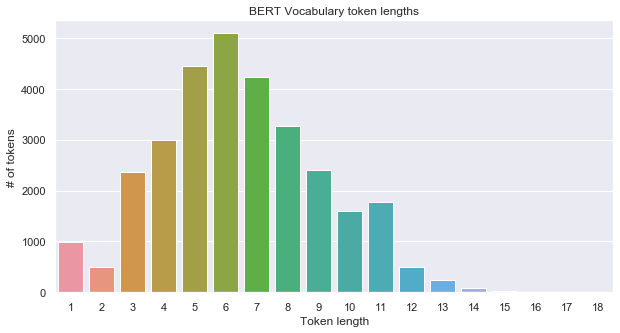

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style='darkgrid')

plt.rcParams["figure.figsize"] = (10,5)

# Get the length of of every token
token_lengths = [len(token) for token in tokenizer.vocab.keys()]

# Plot the number of tokens of each length
sns.countplot(token_lengths)
plt.title('BERT Vocabulary token lengths')
plt.xlabel('Token length')
plt.ylabel('# of tokens')

**Does the BERT vocab contain misspellings?**

According to the BERT paper, "the pre-training procedure largely follows the existing literature on language model pre-training. For the pre-training corpus, the authors used the BooksCorpus, which contains 800 million words as well as the English Wikipedia, which contains 2500 million words". The authors chose a document-level corpus rather than a shuffled-level corpus in order to extract long contiguous sequences. 

It appears that the BERT vocab explicitly *does not contain any misspelled words*, despite there being a chance that a Wikipedia article may contain misspellings. After all, Wikipedia articles are often revised and corrected.

**Does the BERT vocab contain contractions, such as "can't" or "cant"?**

It does not. It appears that the BERT tokenizer separates any words that contain any punctucations or symbols. It also does not replace them by the incorrect spelling (without the apostrophe).

**Does the BERT vocab contain any names?**

Install wget: <code>pip install wget</code>

We can use the Gutenberg's list of names, which contains roughly 22K names and run it against the BERT vocab to find out whether the vocab contains any names. Other collections of names could also be used, as the Gutenberg contains many foreign names as well.

In [6]:
import wget

url = 'http://www.gutenberg.org/files/3201/files/NAMES.TXT'

wget.download(url, 'names.txt')

'names.txt'

In [9]:
# Read these names
with open('names.txt', 'rb') as f:
    names_encoded = f.readlines()
    
names = []

# Decode the names, convert them to lowercase and strip newlines
for name in names_encoded:
    try:
        names.append(name.rstrip().lower().decode('utf-8'))
    except:
        continue
        
print('Number of names:', len(names))

Number of names: 21985


In [10]:
num_names = 0

for name in names:
    if name in tokenizer.vocab:
        num_names += 1

print('There are', num_names, 'in the BERT vocabulary.')

There are 3869 in the BERT vocabulary.


**Does the BERT vocab contain any numbers?**

In [14]:
amnt_of_numbers = 0

for token in tokenizer.vocab.keys():
    if token.isdigit():
        amnt_of_numbers += 1

print('The BERT vocab contains:', amnt_of_numbers, 'numbers.')

The BERT vocab contains: 881 numbers.


It would appear that many of these numbers are dates.

In [18]:
count = 0
for i in range(1500, 2021):
    if str(i) in tokenizer.vocab:
        count += 1
    
print('The BERT vocab includes', count, 'out of', 2021-1500, 'dates from 1500 - 20201.')
print('This is roughly', round(count/amnt_of_numbers*100), '% of the numbers.')

The BERT vocab includes 390 out of 521 dates from 1500 - 20201.
This is roughly 44 % of the numbers.


# Fine-tuning BERT

As previously mentioned, BERT is a pre-trained model that understands a lot about English. This simplifies much of the work that we have to perform. We can take this model right off of the shelf, do some fine-tuning and achieve faster results. This means we do not have to train our own model. Furthermore, this pre-trained model could give better results compared to what we could come up with. 

**Potential issues:**

BERT is a very large model: the base form has 30K tokens mapped to embeddings which have 768 values each. Thus, the embedding layer has roughly 24 million weights. BERT also has 12 Transformers stacked on top of one another. Each Transformer has roughly 7 million weights, or in total roughly 85 million weights. This results in a total of rouhgly 109 million weights or rouhgly 417 MB in size.

Jargon could be an issue when using the pre-trained BERT model, however, the complaints from our dataset are fairly general and do not contain that many domain-specific words. Nonetheless, this potential shortcoming is important to note.

**BERT provides its own tokenizer.**

BERT expects input data in a specific format, with special tokens to mark the beginning ([CLS]) and separation/end of sentences ([SEP]). We must first tokenize our complaints into tokens that correspond to BERT's vocabulary.

We will be using a balanced version of our dataset.

## Dataset pre-processing

### Product consolidation

We can consolidate certain labels into each other to make it easier on ourselves:

* Consolidate “Credit reporting” into “Credit reporting, credit repair services, or other personal consumer reports”.
* Consolidate “Credit card” into “Credit card or prepaid card”.
* Consolidate “Payday loan” into “Payday loan, title loan, or personal loan”.
* Consolidate “Virtual currency” into “Money transfer, virtual currency, or money service”.
* “Other financial service” has very few number of complaints and it does not add much of value, so we will remove it.

**First look**

In [36]:
import pandas as pd

df = pd.read_csv("complaints-2020-01-22_08_24.csv", encoding="utf-8")

df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,07/23/19,"Credit reporting, credit repair services, or o...",Credit reporting,Credit monitoring or identity theft protection...,Problem canceling credit monitoring or identif...,I have complained many times that the credit r...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,CA,926XX,None,Consent provided,Web,07/23/19,Closed with explanation,Yes,NaN,3315279
1,07/26/19,Debt collection,I do not know,False statements or representation,Attempted to collect wrong amount,please review the current fraud account and al...,Company believes it acted appropriately as aut...,"Ideal Collection Services, Inc.",FL,333XX,None,Consent provided,Web,07/26/19,Closed with explanation,Yes,NaN,3319487
2,06/03/19,Debt collection,I do not know,Attempts to collect debt not owed,Debt was paid,Called multiple times over the years for a deb...,None,"ONEMAIN FINANCIAL HOLDINGS, LLC.",FL,327XX,None,Consent provided,Web,06/07/19,Closed with explanation,Yes,NaN,3262794
3,07/03/19,Debt collection,Other debt,Attempts to collect debt not owed,Debt was result of identity theft,I sent in a letter to the company to have them...,None,"Diversified Consultants, Inc.",VA,232XX,None,Consent provided,Web,07/03/19,Closed with explanation,Yes,NaN,3295208
4,07/14/19,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Received unsolicited financial product or insu...,On XX/XX/19 I applied for a Debt Relief Produc...,None,"ClearOne Advantage, LLC",PA,191XX,"Older American, Servicemember",Consent provided,Web,07/18/19,Closed with explanation,Yes,NaN,3306130


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485701 entries, 0 to 485700
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Date received                 485701 non-null  object
 1   Product                       485701 non-null  object
 2   Sub-product                   485701 non-null  object
 3   Issue                         485701 non-null  object
 4   Sub-issue                     485701 non-null  object
 5   Consumer complaint narrative  485701 non-null  object
 6   Company public response       485701 non-null  object
 7   Company                       485701 non-null  object
 8   State                         485701 non-null  object
 9   ZIP code                      485701 non-null  object
 10  Tags                          485701 non-null  object
 11  Consumer consent provided?    485701 non-null  object
 12  Submitted via                 485701 non-null  object
 13 

**Consolidation**

In [38]:
df.loc[df['Product'] == 'Credit reporting', 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
df.loc[df['Product'] == 'Credit card', 'Product'] = 'Credit card or prepaid card'
df.loc[df['Product'] == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'
df.loc[df['Product'] == 'Virtual currency', 'Product'] = 'Money transfer, virtual currency, or money service'
df = df[df.Product != 'Other financial service']

We need **cufflinks** to link plotly to pandas. <code>pip install cufflinks --upgrade</code>

This adds the function <code>iplot</code> to our arsenal of code.

In [43]:
import cufflinks
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')


df['Product'].value_counts().sort_values(ascending=False).iplot(kind='bar', yTitle='Number of Complaints', title='Number complaints in each product')

This reduces the amount of products from 18 to 13.

### Product balancing

We will first create a more balanced version our dataset, based on the 'Product'.

In [47]:
df_bal1 = df.copy()

indexNames = df_bal1[df_bal1["Product"] == "Credit reporting, credit repair services, or other personal consumer reports"].index
df_bal1.drop(indexNames, inplace=True)
indexNames = df_bal1[df_bal1["Product"] == "Debt collection"].index
df_bal1.drop(indexNames, inplace=True)
indexNames = df_bal1[df_bal1["Product"] == "Mortgage"].index
df_bal1.drop(indexNames, inplace=True)


df_bal1 = df_bal1.append(df.loc[df["Product"] == 'Credit reporting, credit repair services, or other personal consumer reports'].sample(frac=0.3))
df_bal1 = df_bal1.append(df.loc[df["Product"] == 'Debt collection'].sample(frac=0.3))
df_bal1 = df_bal1.append(df.loc[df["Product"] == 'Mortgage'].sample(frac=0.5))

In [49]:
df_bal1['Product'].value_counts().sort_values(ascending=False).iplot(kind='bar', yTitle='Number of Complaints', title='Number complaints in each product')

In [50]:
df_bal2 = df_bal1.copy()

indexNames = df_bal2[df_bal2["Product"] == "Credit reporting, credit repair services, or other personal consumer reports"].index
df_bal2.drop(indexNames, inplace=True)
indexNames = df_bal2[df_bal2["Product"] == "Debt collection"].index
df_bal2.drop(indexNames, inplace=True)
indexNames = df_bal2[df_bal2["Product"] == "Credit reporting"].index
df_bal2.drop(indexNames, inplace=True)
indexNames = df_bal2[df_bal2["Product"] == "Credit card or prepaid card"].index
df_bal2.drop(indexNames, inplace=True)
indexNames = df_bal2[df_bal2["Product"] == "Mortgage"].index
df_bal2.drop(indexNames, inplace=True)
indexNames = df_bal2[df_bal2["Product"] == "Student loan"].index
df_bal2.drop(indexNames, inplace=True)

df_bal2 = df_bal2.append(df_bal1.loc[df_bal1["Product"] == 'Credit reporting, credit repair services, or other personal consumer reports'].sample(frac=0.45))
df_bal2 = df_bal2.append(df_bal1.loc[df_bal1["Product"] == 'Debt collection'].sample(frac=0.55))
df_bal2 = df_bal2.append(df_bal1.loc[df_bal1["Product"] == 'Credit reporting'].sample(frac=0.55))
df_bal2 = df_bal2.append(df_bal1.loc[df_bal1["Product"] == 'Credit card or prepaid card'].sample(frac=0.55))
df_bal2 = df_bal2.append(df_bal1.loc[df_bal1["Product"] == 'Mortgage'].sample(frac=0.58))
df_bal2 = df_bal2.append(df_bal1.loc[df_bal1["Product"] == 'Student loan'].sample(frac=0.6))

In [52]:
df_bal2['Product'].value_counts().sort_values(ascending=False).iplot(kind='bar', yTitle='Number of Complaints', title='Number complaints in each product')

In [55]:
df_bal3 = df_bal2.copy()

indexNames = df_bal3[df_bal3["Product"] == "Credit reporting, credit repair services, or other personal consumer reports"].index
df_bal3.drop(indexNames, inplace=True)
indexNames = df_bal3[df_bal3["Product"] == "Checking or savings account"].index
df_bal3.drop(indexNames, inplace=True)
indexNames = df_bal3[df_bal3["Product"] == "Mortgage"].index
df_bal3.drop(indexNames, inplace=True)
indexNames = df_bal3[df_bal3["Product"] == "Debt collection"].index
df_bal3.drop(indexNames, inplace=True)
indexNames = df_bal3[df_bal3["Product"] == "Credit card or prepaid card"].index
df_bal3.drop(indexNames, inplace=True)
indexNames = df_bal3[df_bal3["Product"] == "Student loan"].index
df_bal3.drop(indexNames, inplace=True)
indexNames = df_bal3[df_bal3["Product"] == "Bank account or service"].index
df_bal3.drop(indexNames, inplace=True)

df_bal3 = df_bal3.append(df_bal2.loc[df_bal2["Product"] == 'Credit reporting, credit repair services, or other personal consumer reports'].sample(n=10000))
df_bal3 = df_bal3.append(df_bal2.loc[df_bal2["Product"] == 'Checking or savings account'].sample(n=10000))
df_bal3 = df_bal3.append(df_bal2.loc[df_bal2["Product"] == 'Mortgage'].sample(n=10000))
df_bal3 = df_bal3.append(df_bal2.loc[df_bal2["Product"] == 'Debt collection'].sample(n=10000))
df_bal3 = df_bal3.append(df_bal2.loc[df_bal2["Product"] == 'Credit card or prepaid card'].sample(n=10000))
df_bal3 = df_bal3.append(df_bal2.loc[df_bal2["Product"] == 'Student loan'].sample(n=10000))
df_bal3 = df_bal3.append(df_bal2.loc[df_bal2["Product"] == 'Bank account or service'].sample(n=10000))

In [56]:
df_bal3['Product'].value_counts().sort_values(ascending=False).iplot(kind='bar', yTitle='Number of Complaints', title='Number complaints in each product')

In [195]:
df = df_bal3.copy()

In [196]:
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
9,06/15/19,"Payday loan, title loan, or personal loan",Installment loan,Problem with the payoff process at the end of ...,None,They would not let me pay my loan off 2 days b...,None,"Big Picture Loans, LLC",IN,477XX,None,Consent provided,Web,06/15/19,Closed with explanation,Yes,NaN,3276316
12,07/25/19,"Payday loan, title loan, or personal loan",Installment loan,Charged fees or interest you didn't expect,None,Service Finance are liars and are charging me ...,None,"Service Finance Holdings, LLC",TX,None,None,Consent provided,Web,07/25/19,Closed with non-monetary relief,Yes,NaN,3318533
38,06/23/19,Vehicle loan or lease,Loan,Problems at the end of the loan or lease,Problem with paying off the loan,On XX/XX/XXXX I signed a car loan agreement to...,None,"HUNTINGTON NATIONAL BANK, THE",TX,750XX,None,Consent provided,Web,06/23/19,Closed with non-monetary relief,Yes,NaN,3284279
44,08/13/19,"Money transfer, virtual currency, or money ser...",Debt settlement,Fraud or scam,None,We hired XXXX XXXX and XXXX XXXX XXXX Debt Col...,None,ALLIED NATIONAL INC,NY,117XX,None,Consent provided,Web,08/13/19,Untimely response,No,NaN,3339246
52,07/31/19,"Payday loan, title loan, or personal loan",Payday loan,Problem with the payoff process at the end of ...,None,"I BORROWED {$200.00}, IN AN FINANCIAL EMERGENC...",Company believes it acted appropriately as aut...,"Harpeth Financial Services, LLC",TN,None,Servicemember,Consent provided,Web,08/02/19,Closed with explanation,Yes,NaN,3324772


In [197]:
df.shape

(106301, 18)

### Product label encoding

We will encode the Product label using a <code>LabelEncoder</code>.

In [198]:
from sklearn.preprocessing import LabelEncoder

# Encode the Product label
labelencoder = LabelEncoder()
df['Product Label'] = labelencoder.fit_transform(df['Product'])

# Keep only the Product label and the consumer complaint narrative
df = df[['Consumer complaint narrative', 'Product', 'Product Label']]

df.head()

,Consumer complaint narrative,Product,Product Label
9,They would not let me pay my loan off 2 days b...,"Payday loan, title loan, or personal loan",9
12,Service Finance are liars and are charging me ...,"Payday loan, title loan, or personal loan",9
38,On XX/XX/XXXX I signed a car loan agreement to...,Vehicle loan or lease,12
44,We hired XXXX XXXX and XXXX XXXX XXXX Debt Col...,"Money transfer, virtual currency, or money ser...",6
52,"I BORROWED {$200.00}, IN AN FINANCIAL EMERGENC...","Payday loan, title loan, or personal loan",9


In [199]:
label_counts = pd.DataFrame(df['Product'].value_counts())
label_counts

,Product
Mortgage,10000
Student loan,10000
Checking or savings account,10000
Bank account or service,10000
"Credit reporting, credit repair services, or other personal consumer reports",10000
Debt collection,10000
Credit card or prepaid card,10000
Consumer Loan,9473
Vehicle loan or lease,8079
"Payday loan, title loan, or personal loan",8051


Create an array with the label names in the order they were numerically encoded. We later use these when plotting the model performance data.

In [200]:
label_values = list(label_counts.index)
order = list(pd.DataFrame(df['Product Label'].value_counts()).index)
label_values = [l for _,l in sorted(zip(order, label_values))]

label_values

['Credit card or prepaid card',
 'Debt collection',
 'Consumer Loan',
 'Credit reporting, credit repair services, or other personal consumer reports',
 'Bank account or service',
 'Checking or savings account',
 'Money transfer, virtual currency, or money service',
 'Money transfers',
 'Student loan',
 'Payday loan, title loan, or personal loan',
 'Prepaid card',
 'Mortgage',
 'Vehicle loan or lease']

### Dataset cleaning

Contrary to previous dataset cleaning and preprocessing for previous models that we have trained, we will not be removing punctuation, because BERT will label these. However, when numbers with a decimal are mentioned, the numbers may be removed, but a distinction between a period and a decimal point cannot easily be made.

Furthermore, it is not immediately clear what to do with the censored data. Should we leave it in or take it out? As an experiment, we will run a model with and without this censored data. We chose to remove numbers, because 44% of the numbers in the BERT vocabulary seem to be referring to historical dates, which are irrelevant in this dataset. It is not immediately obvious what purpose the other 56% of numbers are included for.

We have 3 datasets:
* A fully cleaned dataset;
* A nearly fully cleaned dataset (punctuation still included);
* A partially cleaned dataset (does not remove censored words (XXXX) and leaves all special characters, including punctuation, in).

In [201]:
df_backup = df.copy();

In [202]:
import re
import string


def clean_document_full(complaint):
    # turn text to lowercase
    complaint = complaint.lower()
    # remove URLs
    complaint = re.sub('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '', complaint)
    complaint = re.sub('https? ?: ?// ?(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '', complaint)
    # removed censored words
    complaint = re.sub('[xxxx]{4}', '', complaint)
    complaint = re.sub('[XXXX]{4}', '', complaint)
    # remove normal dates and censored dates
    complaint = re.sub('[\dx]{0,2}/?[\dx]{0,2}/[\dx]{0,4}', '', complaint)
    # remove non-sensical characters
    complaint = re.sub('[\[\,\#\'\"\_\-\(\)\:\$\;\?\%\}\{\@\]\/\.\&\!\|]',' ', complaint)
    complaint = re.sub('\n', '', complaint)
    complaint = re.sub('\t', '', complaint)
    # remove numbers
    complaint = re.sub('[\d]', ' ', complaint)
    # normalise spaces to just one space
    complaint = re.sub(" +", " ", complaint);
    return complaint

def clean_document_nearly_full(complaint):
    # turn text to lowercase
    complaint = complaint.lower()
    # remove URLs
    complaint = re.sub('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '', complaint)
    complaint = re.sub('https? ?: ?// ?(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '', complaint)
    # removed censored words
    complaint = re.sub('[xxxx]{4}', '', complaint)
    complaint = re.sub('[XXXX]{4}', '', complaint)
    # remove normal dates and censored dates
    complaint = re.sub('[\dx]{0,2}/?[\dx]{0,2}/[\dx]{0,4}', '', complaint)
    # removes:  [ # " _ - ( ) : $ ; % } { @ ] / & | \n \t
    complaint = re.sub('[\[\#\"\_\-\(\)\:\$\;\%\}\{\@\]\/\&\|]',' ', complaint)
    complaint = re.sub('\n', '', complaint)
    complaint = re.sub('\t', '', complaint)
    # remove numbers
    complaint = re.sub('[\d]', ' ', complaint)
    # normalise spaces to just one space
    complaint = re.sub(" +", " ", complaint);
    return complaint

# Does not remove censored words (XXXX) or special characters
def clean_document_partial(complaint):
    # turn text to lowercase
    complaint = complaint.lower()
    # remove URLs
    complaint = re.sub('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '', complaint)
    complaint = re.sub('https? ?: ?// ?(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '', complaint)
    # remove newlines and tabs
    complaint = re.sub('\n', '', complaint)
    complaint = re.sub('\t', '', complaint)
    # remove numbers
    complaint = re.sub('[\d]', ' ', complaint)
    # normalise spaces to just one space
    complaint = re.sub(" +", " ", complaint);
    return complaint

**Clean full**

In [203]:
df['Consumer complaint narrative'] = df['Consumer complaint narrative'].apply(clean_document_full)

In [204]:
df_fully_cleaned = df.copy();

In [205]:
df = df_backup.copy();

**Clean nearly full**

In [206]:
df = df_backup.copy();

In [207]:
df['Consumer complaint narrative'] = df['Consumer complaint narrative'].apply(clean_document_nearly_full)

In [208]:
df_nearly_fully_cleaned = df.copy();

In [209]:
df = df_backup.copy();

**Clean partial**

In [210]:
df = df_backup.copy();

In [211]:
df['Consumer complaint narrative'] = df['Consumer complaint narrative'].apply(clean_document_partial)

In [212]:
df_partially_cleaned = df.copy();

In [213]:
df = df_backup.copy();

**Examples**

In [214]:
df['Consumer complaint narrative'][38] # Original

'On XX/XX/XXXX I signed a car loan agreement to finance my 2008 XXXX XXXX XXXX   car. \nThe loan amount was {$5400.00}, that is the amount that was financed. The interest was 8.54 %. The total amount to be paid back was {$6500.00}, in 48 months payments. The amount per month was {$130.00}. The payments began on XX/XX/XXXX and were to end on XX/XX/XXXX. Fortunately I made some payments that were much more than the monthly required amount of {$130.00}. That means that the final payment is now to be well before XX/XX/XXXX. In fact I did my last payment in XX/XX/XXXX. In addition I have mailed them a final payment of {$180.00} ( {$50.00} deferral fee and {$130.00} for the payment I skipped XX/XX/XXXX ). \nDuring the term of loan I received no communication, no monthly account statement and no notice of late payments. Also I have been making my payment on time every month with the exception of the skipped payment in XX/XX/XXXX. \nI have called the bank to let them know I moved from the addr

In [215]:
df_fully_cleaned['Consumer complaint narrative'][38] # Fully cleaned

'on i signed a car loan agreement to finance my car the loan amount was that is the amount that was financed the interest was the total amount to be paid back was in months payments the amount per month was the payments began on and were to end on fortunately i made some payments that were much more than the monthly required amount of that means that the final payment is now to be well before in fact i did my last payment in in addition i have mailed them a final payment of deferral fee and for the payment i skipped during the term of loan i received no communication no monthly account statement and no notice of late payments also i have been making my payment on time every month with the exception of the skipped payment in i have called the bank to let them know i moved from the address that was on the loan agreement then called the bank again to let them know i had moved out of state then a year later when i moved again to a different address all times i gave them my new address and 

In [216]:
df_nearly_fully_cleaned['Consumer complaint narrative'][38] # Fully cleaned, except for punctuation

"on i signed a car loan agreement to finance my car. the loan amount was . , that is the amount that was financed. the interest was . . the total amount to be paid back was . , in months payments. the amount per month was . . the payments began on and were to end on . fortunately i made some payments that were much more than the monthly required amount of . . that means that the final payment is now to be well before . in fact i did my last payment in . in addition i have mailed them a final payment of . . deferral fee and . for the payment i skipped . during the term of loan i received no communication, no monthly account statement and no notice of late payments. also i have been making my payment on time every month with the exception of the skipped payment in . i have called the bank to let them know i moved from the address that was on the loan agreement. then called the bank again to let them know i had moved out of state. then a year later when i moved again to a different addres

In [217]:
df_partially_cleaned['Consumer complaint narrative'][38] # Partially cleaned

'on xx/xx/xxxx i signed a car loan agreement to finance my xxxx xxxx xxxx car. the loan amount was {$ . }, that is the amount that was financed. the interest was . %. the total amount to be paid back was {$ . }, in months payments. the amount per month was {$ . }. the payments began on xx/xx/xxxx and were to end on xx/xx/xxxx. fortunately i made some payments that were much more than the monthly required amount of {$ . }. that means that the final payment is now to be well before xx/xx/xxxx. in fact i did my last payment in xx/xx/xxxx. in addition i have mailed them a final payment of {$ . } ( {$ . } deferral fee and {$ . } for the payment i skipped xx/xx/xxxx ). during the term of loan i received no communication, no monthly account statement and no notice of late payments. also i have been making my payment on time every month with the exception of the skipped payment in xx/xx/xxxx. i have called the bank to let them know i moved from the address that was on the loan agreement. then 

### Removing complaints that have very few words

There are some complaints that have 0 to very few words. We disregard any complaint that has fewer than 10 words, because we deem that these do not have any useful information.

#### Fully cleaned dataset

In [218]:
lengths = [len(df_fully_cleaned.iloc[i]['Consumer complaint narrative'].split()) for i in range(len(df_fully_cleaned))]
print(max(lengths))
print(min(lengths))

5894
0


In [219]:
df_fully_cleaned.shape

(106301, 3)

In [220]:
df_fully_cleaned = df_fully_cleaned[[l >= 10 for l in lengths]]

In [221]:
df_fully_cleaned.shape

(105572, 3)

In [222]:
print(106301-105572, 'complaints were omitted')

729 complaints were omitted


#### Nearly fully cleaned dataset

In [223]:
lengths = [len(df_nearly_fully_cleaned.iloc[i]['Consumer complaint narrative'].split()) for i in range(len(df_nearly_fully_cleaned))]
print(max(lengths))
print(min(lengths))

5973
1


In [224]:
df_nearly_fully_cleaned.shape

(106301, 3)

In [225]:
df_nearly_fully_cleaned = df_nearly_fully_cleaned[[l >= 10 for l in lengths]]

In [226]:
df_nearly_fully_cleaned.shape

(105582, 3)

In [227]:
print(106301-105582, 'complaints were omitted')

719 complaints were omitted


#### Partially cleaned dataset

In [228]:
lengths = [len(df_partially_cleaned.iloc[i]['Consumer complaint narrative'].split()) for i in range(len(df_partially_cleaned))]
print(max(lengths))
print(min(lengths))

6328
1


In [229]:
df_partially_cleaned.shape

(106301, 3)

In [230]:
df_partially_cleaned = df_partially_cleaned[[l >= 10 for l in lengths]]

In [231]:
df_partially_cleaned.shape

(105682, 3)

In [232]:
print(106301-105582, 'complaints were omitted')

719 complaints were omitted


### Export to csv

In [233]:
df_fully_cleaned.to_csv('consumer_complaint_bert_fully_cleaned.csv', index=False)
df_nearly_fully_cleaned.to_csv('consumer_complaint_bert_nearly_fully_cleaned.csv', index=False)
df_partially_cleaned.to_csv('consumer_complaint_bert_partially_cleaned.csv', index=False)

## BERT Fine-Tuning

Install the transformers package from Hugging Face to use one of its pre-trained BERT models.  
<code>pip install transformers</code>

In [235]:
# Fully cleaned
df_fully_cleaned = pd.read_csv('consumer_complaint_bert_fully_cleaned.csv')
# Nearly fully cleaned
df_nearly_fully_cleaned = pd.read_csv('consumer_complaint_bert_nearly_fully_cleaned.csv')
# Partially cleaned
df_partially_cleaned = pd.read_csv('consumer_complaint_bert_partially_cleaned.csv')

We need to create 2 arrays: one with the textual data, our feature data, and one with the numerically encoded labels, which represents our target.

In [236]:
# #### Textual data ####
# Fully cleaned
texts_fully = df_fully_cleaned['Consumer complaint narrative'].values

# Nearly fully cleaned
texts_nearly_fully = df_nearly_fully_cleaned['Consumer complaint narrative'].values

# Partially cleaned
texts_partially = df_partially_cleaned['Consumer complaint narrative'].values

# #### labels for the target ####
labels_fully = df_fully_cleaned['Product Label'].values

### How to Fine-Tune BERT for Text Classification?

BERT has 2 constraints:
* All sentences must be padded or truncated to a single, fixed length.
* The maximum sentence length is 512 tokens.

This padding is done with a [PAD] token, which is the index 0 in the BERT vocab.

A paper ([source](https://arxiv.org/pdf/1905.05583.pdf)) was published that investigates the maximum sentence length problem. The simplest solution is **truncation**, which drops some of the tokens and hope that the remaining text is enough to perform the task well. This could be done at the end (head-only), in the middle (head+tail) or at the start (tail-only) of our complaint. According to the researchers of this paper, the head+tail approach performed best (based on test error rates). Their training set was IMDB.

Another solution is **chunking**, which divides the text into 512-token chunks and generate embeddings for these chunks separately. The authors of the paper combined the embeddings for the different chunks before performing the final classification. This method did not, however, outperform the head+tail solution.

Alternatively, a document (our complaint) could also be summarized (such as extractive summarization; picking the most purtinant tokens in the document) into a length that the model can process.

### Tokenization

We *must* use the tokenizer provided by the model, because the model has a specific, fixed vocab. Furthermore, the BERT tokenizer handles words that do not appear in the vocab in a very particular way (splitting them into subwords or tokens), as briefly touched on during the introduction.

**Example**

In [254]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

print('Original Text: ', texts_fully[0], '\n')
print('Tokenized Text: ', tokenizer.tokenize(texts_fully[0]), '\n')
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(texts_fully[0])))

ImportError: FloatProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

We now tokenize and encode the entire dataset, performing the following:
* Tokenize the text as shown above;
* Encode it to the corresponding numeric values for each token;
* Truncate it to the maximum sequence length of 300;
* Pad the tokens positions greater than 300;
* Include the special token IDs to mark the beginning and end of each sequence.

In [251]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
text_fully_ids  = []

# For every sentence...
for text in texts_fully:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', texts_fully[0])
print('Token IDs:', text_fully_ids[0])

AttributeError: 'BertTokenizer' object has no attribute 'encode'

https://github.com/vilcek/fine-tuning-BERT-for-text-classification/blob/master/02-data-classification.ipynb

https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03#:~:text=BERT%20theoretically%20allows%20us%20to,task%2Dspecific%20fine%2Dtuning.&text=BERT%20works%20similarly%20to%20the,new%20sequences%20are%20coming%20in.  
https://colab.research.google.com/drive/1Y4o3jh3ZH70tl6mCd76vz_IxX23biCPP#scrollTo=Z474sSC6oe7A    
https://www.youtube.com/watch?v=_eSGWNqKeeY&t=1044s  

https://mc.ai/using-bert-for-classifying-documents-with-long-texts/  
https://github.com/google-research/bert/blob/master/predicting_movie_reviews_with_bert_on_tf_hub.ipynb  

https://github.com/ArmandDS/bert_for_long_text/blob/master/final_bert_long_docs.ipynb

https://www.kaggle.com/fulowa/bert-tf-hub-complaints-dataset


https://huggingface.co/transformers/model_doc/bert.html#berttokenizer